In [46]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from openai import OpenAI
import google.generativeai as genai
from google.generativeai import GenerativeModel, configure
import tiktoken

from src.eval_helpers import compute_ci

In [3]:
### load raw concept annotations from legal scholars
concepts_df = pd.read_csv("../data/csvs/concepts.csv", dtype={'ID': 'str'})
concepts_df = concepts_df.sort_values(by='ID').reset_index(drop=True)
print(concepts_df.shape)
concepts_df.head()

(471, 44)


,ID,Case URL,Author,Physical Harm,EXISTENCE OF DUTY \n(tag §7(a) in all duty cases)\n,Existence of Duty (policy issues),Judge and Jury \n(US only),No Liability for Omissions\n(tag in all omissions cases),Affirmative Duty Based on Statute\n(Eng cases: tag where C makes claim for breach of SD),Duty Based on Prior Conduct,Duty Based on Special Relationship with Another,Duty Based on Special Relationship with a Third Party which Poses Risks to the Claimant,Duty Based on Undertaking to the Claimant,Duty Based on Undertaking to Another\n(see comments on Eng cases),Duty Based on Taking Charge of Another,Emergency,"Children\n(a, b, c)","Disability\n(a, b, c)",Knowledge and Skills,NEGLIGENCE\n(tag in all breach cases),"Custom\n(a, b)",Statutory Violations as Negligence Per Se\n(Eng cases: tag where C makes claim for SD and court discusses if SD was breached),"Excused Violations of Statute \n(US only)\n(a, b, c, d, e)","Statutory Compliance\n(a, b)",Res Ipsa Loquitur,"Negligent Failure to Warn\n(a, b)",Conduct that is Negligent Because it was Instrumental for Claimant's / Third Party's Negligence,Emergency(2),"Children(2)\n(a, b, c)","Disability(2)\n(a, b, c)",Knowledge and Skills(2),CLAIMANT'S NEGLIGENCE\n(tag in all cases where contributory negligence was raised as an issue),"Custom(2)\n(a, b)",Statutory Violations as Negligence Per Se(2)\n(Eng cases: tag where D claims C violated SD and court discusses if SD was breached),"Excused Violations of Statute(2) \n(US only)\n(a, b, c, d, e)","Statutory Compliance(2)\n(a, b)",Res Ipsa Loquitur(2),"Negligent Failure to Warn(2)\n(a, b)",Conduct that is Negligent Because it was Instrumental for the Defendant's Negligence,Marginal case,Potentially other sections of the Restatement relevant,Special concurrence,Makes new law,Comment
0,0001,Caselaw_AZ_1490855,(All),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0002,Caselaw_Alaska_11695007,(All),NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0029,https://cite.case.law/nm/119/609,Sasha,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0082,https://cite.case.law/nm/118/685/,Sasha,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0085,https://cite.case.law/nm/118/385/,Sasha,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocessing

In [4]:
# remove whitespace in column names
concepts_df.columns = concepts_df.columns.str.replace("\n", " ")

In [5]:
renaming = {
    'ID': 'case_id',
    'Physical Harm': 'physical_harm',
    'EXISTENCE OF DUTY  (tag §7(a) in all duty cases) ': 'existence_of_duty',
    'Existence of Duty (policy issues)': 'existence_of_duty_policy',
    'Judge and Jury  (US only)': 'judge_and_jury',
    'No Liability for Omissions (tag in all omissions cases)': 'no_liability_for_omissions',
    'Affirmative Duty Based on Statute (Eng cases: tag where C makes claim for breach of SD)': 'affirmative_duty_based_on_statute',
    'Duty Based on Prior Conduct': 'duty_based_on_prior_conduct',
    'Duty Based on Special Relationship with Another': 'duty_based_on_special_relationship_with_another',
    'Duty Based on Special Relationship with a Third Party which Poses Risks to the Claimant': 'duty_based_on_special_relationship_with_a_third_party_which_poses_risks_to_the_claimant',
    'Duty Based on Undertaking to the Claimant': 'duty_based_on_undertaking_to_the_claimant',
    'Duty Based on Undertaking to Another (see comments on Eng cases)': 'duty_based_on_undertaking_to_another',
    'Duty Based on Taking Charge of Another': 'duty_based_on_taking_charge_of_another',
    'Emergency': 'breach_of_duty_emergency',
    'Children (a, b, c)': 'breach_of_duty_children',
    'Disability (a, b, c)': 'breach_of_duty_disability',
    'Knowledge and Skills': 'breach_of_duty_knowledge_and_skills',
    'NEGLIGENCE (tag in all breach cases)': 'breach_of_duty_negligence',
    'Custom (a, b)': 'breach_of_duty_custom',
    'Statutory Violations as Negligence Per Se (Eng cases: tag where C makes claim for SD and court discusses if SD was breached)': 'breach_of_duty_statutory_violations_as_negligence_per_se',
    'Excused Violations of Statute  (US only) (a, b, c, d, e)': 'breach_of_duty_excused_violations_of_statute',
    'Statutory Compliance (a, b)': 'breach_of_duty_statutory_compliance',
    'Res Ipsa Loquitur': 'breach_of_duty_res_ipsa_loquitor',
    'Negligent Failure to Warn (a, b)': 'breach_of_duty_negligent_failure_to_warn',
    "Conduct that is Negligent Because it was Instrumental for Claimant's / Third Party's Negligence": "breach_of_duty_conduct_that_is_negligent",
    'Emergency(2)': 'contributory_negligence_emergency',
    'Children(2) (a, b, c)': 'contributory_negligence_children',
    'Disability(2) (a, b, c)': 'contributory_negligence_disability',
    'Knowledge and Skills(2)': 'contributory_negligence_knowledge_and_skills',
    "CLAIMANT'S NEGLIGENCE (tag in all cases where contributory negligence was raised as an issue)": "contributory_negligence_negligence",
    'Custom(2) (a, b)': 'contributory_negligence_custom',
    'Statutory Violations as Negligence Per Se(2) (Eng cases: tag where D claims C violated SD and court discusses if SD was breached)': 'contributory_negligence_statutory_violations_as_negligence_per_se',
    'Excused Violations of Statute(2)  (US only) (a, b, c, d, e)': 'contributory_negligence_excused_violations_of_statute',
    'Statutory Compliance(2) (a, b)': 'contributory_negligence_statutory_compliance',
    'Res Ipsa Loquitur(2)': 'contributory_negligence_res_ipsa_loquitur',
    'Negligent Failure to Warn(2) (a, b)': 'contributory_negligence_negligent_failure_to_warn',
    "Conduct that is Negligent Because it was Instrumental for the Defendant's Negligence": "contributory_negligence_conduct_that_is_negligent",
    'Marginal case': 'marginal_case',
    'Potentially other sections of the Restatement relevant': 'potentially_other_sections_of_the_restatment_relevant',
    'Special concurrence': 'special_concurrence',
    'Makes new law': 'makes_new_law'
}

In [6]:
# generate ordered list of column names
all_columns = []
for val in renaming.values():
    all_columns.append(val)

In [7]:
all_columns

['case_id',
 'physical_harm',
 'existence_of_duty',
 'existence_of_duty_policy',
 'judge_and_jury',
 'no_liability_for_omissions',
 'affirmative_duty_based_on_statute',
 'duty_based_on_prior_conduct',
 'duty_based_on_special_relationship_with_another',
 'duty_based_on_special_relationship_with_a_third_party_which_poses_risks_to_the_claimant',
 'duty_based_on_undertaking_to_the_claimant',
 'duty_based_on_undertaking_to_another',
 'duty_based_on_taking_charge_of_another',
 'breach_of_duty_emergency',
 'breach_of_duty_children',
 'breach_of_duty_disability',
 'breach_of_duty_knowledge_and_skills',
 'breach_of_duty_negligence',
 'breach_of_duty_custom',
 'breach_of_duty_statutory_violations_as_negligence_per_se',
 'breach_of_duty_excused_violations_of_statute',
 'breach_of_duty_statutory_compliance',
 'breach_of_duty_res_ipsa_loquitor',
 'breach_of_duty_negligent_failure_to_warn',
 'breach_of_duty_conduct_that_is_negligent',
 'contributory_negligence_emergency',
 'contributory_negligence_c

In [8]:
# relabel columns
concepts_df = concepts_df.rename(columns=renaming)

In [9]:
# drop blank cols
blank_cols = list(concepts_df.columns[concepts_df.isna().sum() == concepts_df.shape[0]])
blank_cols

['breach_of_duty_disability',
 'contributory_negligence_excused_violations_of_statute',
 'contributory_negligence_negligent_failure_to_warn',
 'contributory_negligence_conduct_that_is_negligent']

In [10]:
# drop metadata cols
cols_to_drop = ['Case URL', 'Author', 'Comment'] + blank_cols
concepts_df = concepts_df.drop(cols_to_drop, axis=1)

In [11]:
# binarize multilabel, multiclass columns ignoring case_id
binary_concepts_df = concepts_df.loc[:, 'case_id'].to_frame()
binary_concepts_df[concepts_df.drop(['case_id'], axis=1).columns] = concepts_df.drop(columns='case_id').notnull().astype(np.int64)

print(binary_concepts_df.shape)
binary_concepts_df.head()

(471, 37)


,case_id,physical_harm,existence_of_duty,existence_of_duty_policy,judge_and_jury,no_liability_for_omissions,affirmative_duty_based_on_statute,duty_based_on_prior_conduct,duty_based_on_special_relationship_with_another,duty_based_on_special_relationship_with_a_third_party_which_poses_risks_to_the_claimant,duty_based_on_undertaking_to_the_claimant,duty_based_on_undertaking_to_another,duty_based_on_taking_charge_of_another,breach_of_duty_emergency,breach_of_duty_children,breach_of_duty_knowledge_and_skills,breach_of_duty_negligence,breach_of_duty_custom,breach_of_duty_statutory_violations_as_negligence_per_se,breach_of_duty_excused_violations_of_statute,breach_of_duty_statutory_compliance,breach_of_duty_res_ipsa_loquitor,breach_of_duty_negligent_failure_to_warn,breach_of_duty_conduct_that_is_negligent,contributory_negligence_emergency,contributory_negligence_children,contributory_negligence_disability,contributory_negligence_knowledge_and_skills,contributory_negligence_negligence,contributory_negligence_custom,contributory_negligence_statutory_violations_as_negligence_per_se,contributory_negligence_statutory_compliance,contributory_negligence_res_ipsa_loquitur,marginal_case,potentially_other_sections_of_the_restatment_relevant,special_concurrence,makes_new_law
0,0001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0002,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0029,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0082,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0085,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
rows, cols = binary_concepts_df.shape
total_positives = binary_concepts_df.drop('case_id', axis=1).sum().sum()
balance = total_positives / (rows * (cols -1))
print(f"Sparsity: {1 - balance:.2%}")

Sparsity: 93.11%


### Merge with Outcomes

In [13]:
binary_concepts_df.head()

,case_id,physical_harm,existence_of_duty,existence_of_duty_policy,judge_and_jury,no_liability_for_omissions,affirmative_duty_based_on_statute,duty_based_on_prior_conduct,duty_based_on_special_relationship_with_another,duty_based_on_special_relationship_with_a_third_party_which_poses_risks_to_the_claimant,duty_based_on_undertaking_to_the_claimant,duty_based_on_undertaking_to_another,duty_based_on_taking_charge_of_another,breach_of_duty_emergency,breach_of_duty_children,breach_of_duty_knowledge_and_skills,breach_of_duty_negligence,breach_of_duty_custom,breach_of_duty_statutory_violations_as_negligence_per_se,breach_of_duty_excused_violations_of_statute,breach_of_duty_statutory_compliance,breach_of_duty_res_ipsa_loquitor,breach_of_duty_negligent_failure_to_warn,breach_of_duty_conduct_that_is_negligent,contributory_negligence_emergency,contributory_negligence_children,contributory_negligence_disability,contributory_negligence_knowledge_and_skills,contributory_negligence_negligence,contributory_negligence_custom,contributory_negligence_statutory_violations_as_negligence_per_se,contributory_negligence_statutory_compliance,contributory_negligence_res_ipsa_loquitur,marginal_case,potentially_other_sections_of_the_restatment_relevant,special_concurrence,makes_new_law
0,0001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0002,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0029,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0082,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0085,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
outcomes_all = pd.read_csv("../data/csvs/metadata.csv", dtype={'case_id': 'str'})
outcomes_all.head()

,case_id,file_name,outcome
0,0001,0001_Caselaw_AZ_1490855-Sasha.json,reverse
1,0002,0002_Caselaw_Alaska_11695007-Sasha.json,affirm
2,0029,0029-nm_119_609-Torres v State-Sasha.json,reverse
3,0032,0032-nm_118_685-Baer v Regents of the Universi...,mixed
4,0033,0033-nm_118_385-Diaz ex rel Diaz v Feil-Sasha....,mixed


In [15]:
binary_concepts_df.shape, outcomes_all.shape

((471, 37), (471, 3))

In [16]:
concept_ids = set(np.unique(binary_concepts_df['case_id'])) 
outcome_ids = set(np.unique(outcomes_all['case_id']))

unique_to_outcomes = (concept_ids | outcome_ids) - concept_ids
unique_to_concepts = (concept_ids | outcome_ids) - outcome_ids

In [17]:
unique_to_outcomes, unique_to_concepts

({'0032', '0033', '0036'}, {'0082', '0085', '0385'})

In [23]:
concepts_clean = pd.merge(outcomes_all, binary_concepts_df, how='inner', on='case_id')
concepts_clean.shape

(468, 39)

In [24]:
concepts_clean.head()

,case_id,file_name,outcome,physical_harm,existence_of_duty,existence_of_duty_policy,judge_and_jury,no_liability_for_omissions,affirmative_duty_based_on_statute,duty_based_on_prior_conduct,duty_based_on_special_relationship_with_another,duty_based_on_special_relationship_with_a_third_party_which_poses_risks_to_the_claimant,duty_based_on_undertaking_to_the_claimant,duty_based_on_undertaking_to_another,duty_based_on_taking_charge_of_another,breach_of_duty_emergency,breach_of_duty_children,breach_of_duty_knowledge_and_skills,breach_of_duty_negligence,breach_of_duty_custom,breach_of_duty_statutory_violations_as_negligence_per_se,breach_of_duty_excused_violations_of_statute,breach_of_duty_statutory_compliance,breach_of_duty_res_ipsa_loquitor,breach_of_duty_negligent_failure_to_warn,breach_of_duty_conduct_that_is_negligent,contributory_negligence_emergency,contributory_negligence_children,contributory_negligence_disability,contributory_negligence_knowledge_and_skills,contributory_negligence_negligence,contributory_negligence_custom,contributory_negligence_statutory_violations_as_negligence_per_se,contributory_negligence_statutory_compliance,contributory_negligence_res_ipsa_loquitur,marginal_case,potentially_other_sections_of_the_restatment_relevant,special_concurrence,makes_new_law
0,0001,0001_Caselaw_AZ_1490855-Sasha.json,reverse,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0002,0002_Caselaw_Alaska_11695007-Sasha.json,affirm,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0029,0029-nm_119_609-Torres v State-Sasha.json,reverse,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0091,0091-nm_108_696-Roderick v Lake-Sasha.json,affirm,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0101,0101-nm_107_76-Sheraden v Black-Sasha.json,affirm,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# concepts_clean.to_csv("../data/csvs/concepts_clean.csv", index=False)

# Concept Prediction

### Load Data

In [ ]:
concepts_clean = pd.read_csv("../data/csvs/concepts_clean.csv", dtype={'case_id': str})

root = "../data/cases_json/"

rows, cols = concepts_clean.drop(['case_id', 'file_name', 'outcome'], axis=1).shape
n_cases = rows

### Cost Analysis

In [27]:
### Rough Upper Bound Estimates 
# gpt-4o:         $ /50 cases 
# o3-mini:        $ /50 cases 
# gemini-1.5-pro  $ /50 cases 

model_pricing = {'gpt-4o-2024-11-20': {'input': 2.50, 'output': 10.0},
                 'o1-2024-12-17': {'input': 15.0, 'output': 60.00},
                 'models/gemini-1.5-pro': {'input': 1.25, 'output': 5.00}}

### Check Case Token Length

In [28]:
encoding = tiktoken.get_encoding("o200k_base")

In [29]:
file_lengths = np.zeros((n_cases))
for i in tqdm(range(n_cases)):
    file_path = root + concepts_clean['file_name'][i]
    with open(file_path, encoding='utf-8') as f:
        case_file = json.load(f)

    file_lengths[i] = len(encoding.encode(case_file['text']))

  0%|          | 0/468 [00:00<?, ?it/s]

802.0 23125.0


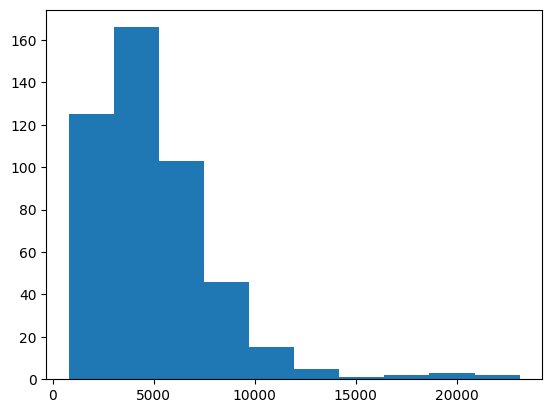

In [30]:
print(file_lengths.min(), file_lengths.max())
plt.hist(file_lengths)
plt.show()

### Concept Definition

In [31]:
concept_definitions = {
    'physical_harm': """Physical harm means the physical impairment of the human body (“bodily harm”) or of real property or tangible personal property (“property damage”). Bodily harm includes physical injury, illness, disease, impairment of bodily function, and death. This concept is present if there is a dispute as to whether the harm suffered falls under the definition of physical harm""",
    'existence_of_duty': """This concept is present if the issue under discussion concerns whether the defendant(s) had a duty to exercise reasonable care (i.e., where the court discusses the existence of a duty of care)""",
    'existence_of_duty_policy': """This concept is present if the discussion considers policy reasons for why a duty might not be deemed to exist.""",
    'judge_and_jury': """This concept is present if the case concerns some dispute between the judge and jury about the facts of the case relating to (i) the actor’s conduct, or (ii) whether the actor’s conduct lacks reasonable care.""",
    'no_liability_for_omissions': """This concept is present if the case concerns an omission (i.e., there is no general duty of care to act for the protection of others). This concept is present even if the case focues on one of the exceptions and without explicitly mentioning the general rule.""",
    'affirmative_duty_based_on_statute': """This concept is present if the court discusses whether an affirmative duty to act exists and relies as part of this discussion on a statute (i.e., a statute that requires an actor to act for the protection of another)""",
    'duty_based_on_prior_conduct': """This concept is present if the discussion concerns whether the defendant should be held to have a duty of care even though the act complained of was an omission, because the defendant, through some prior conduct, created a continuing risk of physical harm, which the defendant should then have taken steps to reduce. E.g., if the defendant’s car broke down, and the defendant did not take steps to remove it from the highway.""",
    'duty_based_on_special_relationship_with_another': """This concept is present if the discussion concerns whether the defendant should be held to have a duty of care even though the act complained of was an omission, because the defendant is in a special relationship with the claimant.""",
    'duty_based_on_special_relationship_with_a_third_party_which_poses_risks_to_the_claimant': """This concept is present if the discussion concerns whether the defendant should be held to have a duty of care even though the act complained of was an omission, because the defendant is in a special relationship with a third party which poses risks to the claimant.""",
    'duty_based_on_undertaking_to_the_claimant': """This concept is present if the discussion concerns whether the defendant should be held to have a duty of care even though the act complained of was an omission, because the defendant undertook to render services which will reduce the risk of harm to another. In English cases, the defendant is termed to have “assumed responsibility” in these cases.""",
    'duty_based_on_undertaking_to_another': """This concept is present if the discussion concerns whether the defendant should be held to have a duty of care even though the act complained of was an omission, because the defendant undertook to render services which will reduce the risk of harm to which a third person is exposed.""",
    'duty_based_on_taking_charge_of_another': """This concept is present if the discussion concerns whether the defendant should be held to have a duty of care even though the act complained of was an omission, because the defendant took charge of another who was imperilled or helpless. In such cases, the defendant has to exercise reasonable care in granting the aid.""",
    'breach_of_duty_emergency': """This concept is present if the courts, in deciding whether the defendant behaved like a reasonably careful person, consider whether the defendant was confronted by an unexpected emergency.""",
    'breach_of_duty_children': """This concept is present if the court, in deciding whether the defendant behaved like a reasonably careful person, considers whether the defendant was a child or if the court discusses whether the child is so young that he/she is incapable of exercising any care or if the court considers a case where the child was engaged in a dangerous adult activity, like driving.""",
    'breach_of_duty_knowledge_and_skills': """This concept is present if in deciding whether the defendant behaved like a reasonably careful person, the court considers the defendant’s particular skills or knowledge (or lack thereof).""",
    'breach_of_duty_negligence': """This concept is present if the issue under discussion concerns whether the defendant(s) breached their duty to exercise reasonable care. This concept should be identified as positive in all ‘breach’ cases.""",
    'breach_of_duty_custom': """This concept is present if, in deciding whether the defendant’s conduct was negligent, the court discusses whether the defendant complied with the custom of the community or in deciding whether the defendant’s conduct was negligent, the court discusses whether the defendant departed from the custom of the community.""",
    'breach_of_duty_statutory_violations_as_negligence_per_se': """This concept is present if in deciding whether the defendant’s conduct was negligent, the court discusses whether the defendant has violated a statutory duty.""",
    'breach_of_duty_excused_violations_of_statute': """This concept is present if the court discusses whether the defendant’s violation of a statute was ‘excusable’ or not.""",
    'breach_of_duty_statutory_compliance': """This concept is present if in deciding whether the defendant’s conduct was negligent, the court discusses whether the defendant has complied with statutory duty or if in deciding whether the defendant’s conduct was negligent, the court considers whether adopting precautions extraneous to a statutory duty would in itself violate a statute.""",
    'breach_of_duty_res_ipsa_loquitor': """This concept is present if in considering whether the defendant’s conduct was negligent, the court considers the doctrine of res ipsa loquitur.""",
    'breach_of_duty_negligent_failure_to_warn': """This concept is present if if the court discusses whether the defendant’s failure to warn was a breach of duty to exercise reasonable care or though the defendant has adequately warned of the relevant risks, the court considers whether the defendant should have adopted further precautions to protect against those risks""",
    'breach_of_duty_conduct_that_is_negligent': """This concept is present if in deciding whether the defendant’s conduct was negligent, the court discusses whether the defendant’s act permitted the improper conduct of the claimant or a third party. """,
    'contributory_negligence_emergency': """This is the same as breach_of_duty_emergency but for the case when the plaintiff is at fault.""",
    'contributory_negligence_children': """This is the same as breach_of_duty_children but for the case when the plaintiff is at fault.""",
    'contributory_negligence_disability': """This is the same as breach_of_duty_disability but for the case when the plaintiff is at fault.""",
    'contributory_negligence_knowledge_and_skills': """This is the same as breach_of_duty_knowledge_and_skills but for the case when the plaintiff is at fault.""",
    'contributory_negligence_negligence': """This is the same as breach_of_duty_negligence but for the case when the plaintiff is at fault.""",
    'contributory_negligence_custom': """This is the same as breach_of_duty_custom but for the case when the plaintiff is at fault.""",
    'contributory_negligence_statutory_violations_as_negligence_per_se': """This is the same as breach_of_duty_statutory_violations_as_negligence_per_se but for the case when the plaintiff is at fault.""",
    'contributory_negligence_statutory_compliance': """This is the same as breach_of_duty_statutory_compliance but for the case when the plaintiff is at fault.""",
    'contributory_negligence_res_ipsa_loquitur': """This is the same as breach_of_duty_negligence_res_ipsa_loquitur but for the case when the plaintiff is at fault.""",
    'marginal_case': "This concept is present if in the case, the facts or legal principles are unclear, uncertain, or borderline, making it difficult to determine the correct outcome. These cases often involve gray areas of the law, where judicial interpretation plays a significant role.",
    'potentially_other_sections_of_the_restatment_relevant': "self_explanatory",
    'special_concurrence': "This concept is present if the judicial opinion written by the judge agrees with the majority’s decision in a case but for different reasons than those expressed in the main opinion.",
    'makes_new_law': "self_explanatory"
}

### Helpers

### OpenAI

In [32]:
class OpenAIConceptPredictor:
    """
    A class to predict the concepts in legal cases using OpenAI's Chat Completion API.
    """
    def __init__(self, model: str):
        """Initialize client and chosen model

        Args:
            model (str, optional): The valid OpenAI model to use.
        """
        self.model = model
        self.client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))
        

    def predict(self, case_file_path: str, concept: str, concepts_dict: dict):
        """{Predict the outcome of the case"""

        with open(case_file_path, encoding='utf-8') as f:
            case_file = json.load(f)
                
        prompt = f"""Your job is to predict the presence of a single legal concept in the attached negligence law case file. Your prediction should be binary, i.e, 1 (concept is present) or 0 (concept is not present). The relevant concepts is {concept} and its it is present if {concepts_dict[concept]}.

        Take your time and think step by step.
        
        Always respond to the user in JSON format with a single key-value pair, with the key being {concept} and the value being either 1 or 0 (as an integer). Include no other text in your response. Ensure the key is spelt correctly by referring to the above definition.

        Law case file to predict concepts from:
        {case_file['text']}"""

        for attempt in range(max_attempts:=5):
            try:
                completion = self.client.chat.completions.create(
                    model=self.model,
                    messages=[
                        {"role": "user", "content": prompt}
                    ],
                    response_format={"type": "json_object"}
                )

                ### cost
                input_cost = completion.usage.prompt_tokens * 1e-6 * model_pricing[self.model]['input']
                output_cost = completion.usage.completion_tokens * 1e-6 * model_pricing[self.model]['output']
                total_cost = input_cost + output_cost
                # print(total_cost)
                # print(completion.choices[0])
                
                preds = json.loads(completion.choices[0].message.content)
                prediction = preds[concept]

                return prediction

            except Exception as e:
                print(e)
                if attempt < max_attempts:
                    print("Failed: Retrying")
                    continue
                else:
                    print("Failed: No More Retries")
                    raise

### Google

In [33]:
class GoogleConceptPredictor:
    def __init__(self, model: str):
        configure(api_key=os.getenv('GOOGLE_API_KEY'))
        self.model = GenerativeModel(model_name=model,
                                     generation_config=genai.GenerationConfig(temperature=0.0,))
        
    def predict(self, case_file_path: str, concept: str, concepts_dict: dict):
        """Predict the outcome of the case"""
        with open(case_file_path, encoding='utf-8') as f:
            case_file = json.load(f)

        prompt = f"""Your job is to predict the presence of a single legal concept in the attached negligence law case file. Your prediction should be binary, i.e, 1 (concept is present) or 0 (concept is not present). The relevant concepts is {concept} and its it is present if {concepts_dict[concept]}.

        Take your time and think step by step.
        
        Always respond to the user in JSON format with a single key-value pair, with the key being {concept} and the value being either 1 or 0 (as an integer). Include no other text in your response. Ensure the key is spelt correctly by referring to the above definition.

        Law case file to predict concepts from:
        {case_file['text']}"""

        for attempt in range(max_attempts:=5):
            try:
                response = self.model.generate_content(prompt)
                
                ### cost
                input_cost = response.usage_metadata.prompt_token_count * 1e-6 * model_pricing[self.model.model_name]['input']
                output_cost = response.usage_metadata.candidates_token_count * 1e-6 * model_pricing[self.model.model_name]['output']
                total_cost = input_cost + output_cost
                # print(total_cost)

                # return response.text

                preds = json.loads(response.text.replace("json", "").replace("```", ""))
                prediction = preds[concept]

                return prediction
            
            except Exception as e:
                print(e)
                if attempt < max_attempts:
                    print("Failed: Retrying")
                    continue
                else:
                    print("Failed: No More Retries")
                    raise

# Predictions

### Testing

In [35]:
concepts_dict = {
    "duty_of_care": "The court determined that the defendant had a legal obligation to exercise reasonable care to prevent foreseeable harm to the plaintiff",
    "breach_of_duty": "The court determined that the defendant failed to meet the standard of care required by law, thereby violating their duty of care owed to the plaintiff",
    "contributory_negligence": "The court determined that the plaintiff failed to exercise reasonable care for their own safety, thereby contributing to their own injury"
}

In [36]:
index = 0
test_case = root + concepts_clean['file_name'][index]

In [38]:
test_judgment_predictor = OpenAIConceptPredictor(model='gpt-4o-2024-11-20')
# test_judgment_predictor = GoogleConceptPredictor(model='gemini-1.5-pro')
predicted_concepts = test_judgment_predictor.predict(test_case, "contributory_negligence", concepts_dict)
predicted_concepts

0

### `GPT-4o`

In [89]:
# rows are the cases, and cols are the concept predictions
concepts_gpt4o = np.zeros((rows, 3))

In [ ]:
for i in tqdm(range(rows)): # change to rows
    case_id = concepts_clean['case_id'][i]
    file_name = concepts_clean['file_name'][i]
    case_file_path = root + file_name
    print(f"Case {i+1}: {file_name}")

    judgment_predictor_gpt4o = OpenAIConceptPredictor(model='gpt-4o-2024-11-20')
    concepts_gpt4o[i, 0] = test_judgment_predictor.predict(case_file_path, "duty_of_care", concepts_dict)
    concepts_gpt4o[i, 1] = test_judgment_predictor.predict(case_file_path, "breach_of_duty", concepts_dict)
    concepts_gpt4o[i, 2] = test_judgment_predictor.predict(case_file_path, "contributory_negligence", concepts_dict)

  0%|          | 0/468 [00:00<?, ?it/s]

Case 1: 0001_Caselaw_AZ_1490855-Sasha.json
Case 2: 0002_Caselaw_Alaska_11695007-Sasha.json
Case 3: 0029-nm_119_609-Torres v State-Sasha.json
Case 4: 0091-nm_108_696-Roderick v Lake-Sasha.json
Case 5: 0101-nm_107_76-Sheraden v Black-Sasha.json
Case 6: 0103-nm_107_707-Corlett ex rel. Estate of Bishop v. Smith-Sasha.json
Case 7: 0104-nm_103_243-Davila ex rel Taylor v Bodelson-Sasha.json
Case 8: 0105-nm_120_751-Yardman v San Juan Downs, Inc-Sasha.json
Case 9: 0110-nm_96_45-Eis v Chesnut-Sasha.json
Case 10: 0113-nm_100_322-State v Williams-Sasha.json
Case 11: 0114-nm_100_794-McNeely v Henry-Sasha.json
Case 12: 0118-nm_121_120-Parker v EI Du Pont-Sasha.json
Case 13: 0120_nm_94_562-O’Brien v Middle Rio-Sasha.json
Case 14: 0121_nm_94_459-Strickland v Roosevelt-Sasha.json
Case 15: 0124-nm_105_487-Thompson v Ruidoso-Sunland-Sasha.json
Case 16: 0126-nm_101_129-Armijo v Albuquerque Anesthesia-Sasha.json
Case 17: 0129-nm_117_217-Blea v City of Espanola-Sasha.json
Case 18: 0131-nm_117_623-Reichert v

In [91]:
concepts_gpt4o

array([[1., 1., 0.],
       [0., 0., 0.],
       [1., 1., 0.],
       ...,
       [0., 0., 0.],
       [1., 1., 0.],
       [1., 1., 0.]], shape=(468, 3))

In [ ]:
task_2_gpt4o = pd.DataFrame(concepts_gpt4o, columns=['duty_of_care', 'breach_of_duty', 'contributory_negligence'], index=concepts_clean['case_id']).reset_index()
task_2_gpt4o.head()

,case_id,duty_of_care,breach_of_duty,contributory_negligence
0,0001,1.0,1.0,0.0
1,0002,0.0,0.0,0.0
2,0029,1.0,1.0,0.0
3,0091,1.0,1.0,0.0
4,0101,1.0,1.0,1.0


In [ ]:
# task_2_gpt4o.to_csv("../data/results/task_2/gpt4o.csv", index=False)

### `o3-mini`

In [84]:
# rows are the cases, and cols are the concept predictions
concepts_o3mini = np.zeros((rows, 3))

In [ ]:
for i in tqdm(range(rows)): # change to rows
    case_id = concepts_clean['case_id'][i]
    file_name = concepts_clean['file_name'][i]
    case_file_path = root + file_name
    print(f"Case {i+1}: {file_name}")

    judgment_predictor_o3mini = OpenAIConceptPredictor(model='o3-mini-2025-01-31')
    concepts_o3mini[i, 0] = test_judgment_predictor.predict(case_file_path, "duty_of_care", concepts_dict)
    concepts_o3mini[i, 1] = test_judgment_predictor.predict(case_file_path, "breach_of_duty", concepts_dict)
    concepts_o3mini[i, 2] = test_judgment_predictor.predict(case_file_path, "contributory_negligence", concepts_dict)

  0%|          | 0/468 [00:00<?, ?it/s]

Case 1: 0001_Caselaw_AZ_1490855-Sasha.json
Case 2: 0002_Caselaw_Alaska_11695007-Sasha.json
Case 3: 0029-nm_119_609-Torres v State-Sasha.json
Case 4: 0091-nm_108_696-Roderick v Lake-Sasha.json
Case 5: 0101-nm_107_76-Sheraden v Black-Sasha.json
Case 6: 0103-nm_107_707-Corlett ex rel. Estate of Bishop v. Smith-Sasha.json
Case 7: 0104-nm_103_243-Davila ex rel Taylor v Bodelson-Sasha.json
Case 8: 0105-nm_120_751-Yardman v San Juan Downs, Inc-Sasha.json
Case 9: 0110-nm_96_45-Eis v Chesnut-Sasha.json
Case 10: 0113-nm_100_322-State v Williams-Sasha.json
Case 11: 0114-nm_100_794-McNeely v Henry-Sasha.json
Case 12: 0118-nm_121_120-Parker v EI Du Pont-Sasha.json
Case 13: 0120_nm_94_562-O’Brien v Middle Rio-Sasha.json
Case 14: 0121_nm_94_459-Strickland v Roosevelt-Sasha.json
Case 15: 0124-nm_105_487-Thompson v Ruidoso-Sunland-Sasha.json
Case 16: 0126-nm_101_129-Armijo v Albuquerque Anesthesia-Sasha.json
Case 17: 0129-nm_117_217-Blea v City of Espanola-Sasha.json
Case 18: 0131-nm_117_623-Reichert v

In [ ]:
task_2_o3mini = pd.DataFrame(concepts_o3mini, columns=['duty_of_care', 'breach_of_duty', 'contributory_negligence'], index=concepts_clean['case_id']).reset_index()
task_2_o3mini.head()

,case_id,duty_of_care,breach_of_duty,contributory_negligence
0,0001,1.0,0.0,0.0
1,0002,0.0,0.0,0.0
2,0029,1.0,1.0,0.0
3,0091,1.0,1.0,0.0
4,0101,1.0,1.0,1.0
...,...,...,...,...
463,1559,1.0,1.0,0.0
464,1561,0.0,1.0,0.0
465,1562,0.0,0.0,0.0
466,1564,1.0,1.0,0.0


In [ ]:
# task_2_o3mini.to_csv("../data/results/task_2/o3mini.csv", index=False)

### `gemini-1.5-pro`

In [100]:
# rows are the cases, and cols are the concept predictions
concepts_gemini = np.zeros((rows, 3))

In [ ]:
for i in tqdm(range(rows)): # change to rows
    case_id = concepts_clean['case_id'][i]
    file_name = concepts_clean['file_name'][i]
    case_file_path = root + file_name
    print(f"Case {i+1}: {file_name}")

    judgment_predictor_gemini = GoogleConceptPredictor(model='gemini-1.5-pro')
    concepts_gemini[i, 0] = test_judgment_predictor.predict(case_file_path, "duty_of_care", concepts_dict)
    concepts_gemini[i, 1] = test_judgment_predictor.predict(case_file_path, "breach_of_duty", concepts_dict)
    concepts_gemini[i, 2] = test_judgment_predictor.predict(case_file_path, "contributory_negligence", concepts_dict)

  0%|          | 0/468 [00:00<?, ?it/s]

Case 1: 0001_Caselaw_AZ_1490855-Sasha.json
Case 2: 0002_Caselaw_Alaska_11695007-Sasha.json
Case 3: 0029-nm_119_609-Torres v State-Sasha.json
Case 4: 0091-nm_108_696-Roderick v Lake-Sasha.json
Case 5: 0101-nm_107_76-Sheraden v Black-Sasha.json
Case 6: 0103-nm_107_707-Corlett ex rel. Estate of Bishop v. Smith-Sasha.json
Case 7: 0104-nm_103_243-Davila ex rel Taylor v Bodelson-Sasha.json
Case 8: 0105-nm_120_751-Yardman v San Juan Downs, Inc-Sasha.json
Case 9: 0110-nm_96_45-Eis v Chesnut-Sasha.json
Case 10: 0113-nm_100_322-State v Williams-Sasha.json
Case 11: 0114-nm_100_794-McNeely v Henry-Sasha.json
Case 12: 0118-nm_121_120-Parker v EI Du Pont-Sasha.json
Case 13: 0120_nm_94_562-O’Brien v Middle Rio-Sasha.json
Case 14: 0121_nm_94_459-Strickland v Roosevelt-Sasha.json
Case 15: 0124-nm_105_487-Thompson v Ruidoso-Sunland-Sasha.json
Case 16: 0126-nm_101_129-Armijo v Albuquerque Anesthesia-Sasha.json
Case 17: 0129-nm_117_217-Blea v City of Espanola-Sasha.json
Case 18: 0131-nm_117_623-Reichert v

In [ ]:
task_2_gemini = pd.DataFrame(concepts_gemini, columns=['duty_of_care', 'breach_of_duty', 'contributory_negligence'], index=concepts_clean['case_id']).reset_index()
task_2_gemini.head()

,case_id,duty_of_care,breach_of_duty,contributory_negligence
0,0001,1.0,1.0,0.0
1,0002,1.0,0.0,0.0
2,0029,1.0,1.0,0.0
3,0091,1.0,1.0,0.0
4,0101,1.0,1.0,1.0
...,...,...,...,...
463,1559,1.0,1.0,0.0
464,1561,1.0,0.0,0.0
465,1562,0.0,0.0,0.0
466,1564,1.0,1.0,0.0


In [ ]:
# task_2_gemini.to_csv("../data/results/task_2/gemini.csv", index=False)

# Evaluation: Easy

In [39]:
def simplify_concepts(concepts_df):
    concepts_easy = concepts_df['case_id'].to_frame()

    concepts_easy['duty_of_care'] = concepts_df[[
        'physical_harm',
        'existence_of_duty',
        'existence_of_duty_policy',
        'judge_and_jury',
        'no_liability_for_omissions',
        'affirmative_duty_based_on_statute',
        'duty_based_on_prior_conduct',
        'duty_based_on_special_relationship_with_another',
        'duty_based_on_special_relationship_with_a_third_party_which_poses_risks_to_the_claimant',
        'duty_based_on_undertaking_to_the_claimant',
        'duty_based_on_undertaking_to_another',
        'duty_based_on_taking_charge_of_another'
    ]].any(axis=1).astype(int)

    concepts_easy['breach_of_duty'] = concepts_df[[
        'breach_of_duty_emergency',
        'breach_of_duty_children',
        # 'breach_of_duty_disability',
        'breach_of_duty_knowledge_and_skills',
        'breach_of_duty_negligence',
        'breach_of_duty_custom',
        'breach_of_duty_statutory_violations_as_negligence_per_se',
        'breach_of_duty_excused_violations_of_statute',
        'breach_of_duty_statutory_compliance',
        'breach_of_duty_res_ipsa_loquitor',
        'breach_of_duty_negligent_failure_to_warn',
        'breach_of_duty_conduct_that_is_negligent'
    ]].any(axis=1).astype(int)

    concepts_easy['contributory_negligence'] = concepts_df[[
        'contributory_negligence_emergency',
        'contributory_negligence_children',
        'contributory_negligence_disability',
        'contributory_negligence_knowledge_and_skills',
        'contributory_negligence_negligence',
        'contributory_negligence_custom',
        'contributory_negligence_statutory_violations_as_negligence_per_se',
        # 'contributory_negligence_excused_violations_of_statute',
        'contributory_negligence_statutory_compliance',
        'contributory_negligence_res_ipsa_loquitur',
        # 'contributory_negligence_negligent_failure_to_warn',
        # 'contributory_negligence_conduct_that_is_negligent'
    ]].any(axis=1).astype(int)

    return concepts_easy

In [40]:
true_concepts_easy = simplify_concepts(concepts_clean)
print(true_concepts_easy.shape)
true_concepts_easy.head()

(468, 4)


,case_id,duty_of_care,breach_of_duty,contributory_negligence
0,0001,0,1,0
1,0002,1,0,0
2,0029,1,0,0
3,0091,0,1,0
4,0101,0,1,0


In [41]:
def score_pred(y_true, y_pred):
    ci_doc = compute_ci(y_true['duty_of_care'], y_pred['duty_of_care'])
    ci_bod = compute_ci(y_true['breach_of_duty'], y_pred['breach_of_duty'])
    ci_cn = compute_ci(y_true['contributory_negligence'], y_pred['contributory_negligence'])

    mean = [ci_doc[0], ci_bod[0], ci_cn[0], np.mean([ci_doc[0], ci_bod[0], ci_cn[0]])]
    lower = np.subtract(mean, [ci_doc[1], ci_bod[1], ci_cn[1], np.mean([ci_doc[1], ci_bod[1], ci_cn[1]])])
    upper = np.subtract([ci_doc[2], ci_bod[2], ci_cn[2], np.mean([ci_doc[2], ci_bod[2], ci_cn[2]])], mean)
    error = np.stack((lower, upper), axis=0)

    return np.array(mean), np.array(error)

### `random`

In [42]:
rows = 468

In [43]:
np.random.seed(0)
concepts_random_easy = np.random.randint(0, 2, size=(rows, 3))
concepts_random_easy.sum().sum() / (rows * 3)

0.5071225071225072

In [44]:
df_random_easy = pd.DataFrame(concepts_random_easy, columns=true_concepts_easy.drop('case_id', axis=1).columns, index=true_concepts_easy['case_id']).reset_index()

In [47]:
mean_random, error_random = score_pred(true_concepts_easy, df_random_easy)
mean_random, error_random

(array([0.47699571, 0.55544679, 0.54986876, 0.52743708]),
 array([[0.04704222, 0.04522814, 0.03706626, 0.0431122 ],
        [0.05079586, 0.03983259, 0.0401097 , 0.04357938]]))

### `gpt_4o`

In [ ]:
task_2_gpt4o = pd.read_csv("../data/results/task_2/gpt4o.csv", dtype={'case_id': str})
task_2_gpt4o.shape

(468, 4)

In [37]:
mean_gpt4o, error_gpt4o = score_pred(true_concepts_easy, task_2_gpt4o)
mean_gpt4o, error_gpt4o

(array([0.38602997, 0.58898036, 0.79762471, 0.59087834]),
 array([[0.0389387 , 0.05686026, 0.03037267, 0.04205721],
        [0.0438166 , 0.04194833, 0.03375318, 0.03983937]]))

### `o3-mini`

In [ ]:
task_2_o3mini = pd.read_csv("../data/results/task_2/o3mini.csv", dtype={'case_id': str})
task_2_o3mini.shape

(468, 4)

In [39]:
mean_o3mini, error_o3mini = score_pred(true_concepts_easy, task_2_o3mini)
mean_o3mini, error_o3mini

(array([0.39318898, 0.58748033, 0.81863966, 0.59976966]),
 array([[0.04253477, 0.04869206, 0.03444471, 0.04189051],
        [0.04057535, 0.04192668, 0.03531591, 0.03927265]]))

### `gemini-1.5-pro`

In [ ]:
task_2_gemini = pd.read_csv("../data/results/task_2/gemini.csv", dtype={'case_id': str})
task_2_gemini.shape

(468, 4)

In [41]:
mean_gemini, error_gemini = score_pred(true_concepts_easy, task_2_gemini)
mean_gemini, error_gemini

(array([0.39084641, 0.5777601 , 0.81562522, 0.59474391]),
 array([[0.04185245, 0.05002095, 0.03210121, 0.04132487],
        [0.04606206, 0.03997155, 0.03062342, 0.03888568]]))

### Visualize

In [42]:
means = np.array([mean_random, mean_gpt4o, mean_o3mini, mean_gemini])
errors = np.array([error_random, error_gpt4o, error_o3mini, error_gemini])
labels = ['Random', 'GPT-4o', 'o3-mini', 'Gemini 1.5 Pro']
x_axis_labels = ['Duty of Care', 'Breach of Duty', 'Contributory Negligence', 'Average']

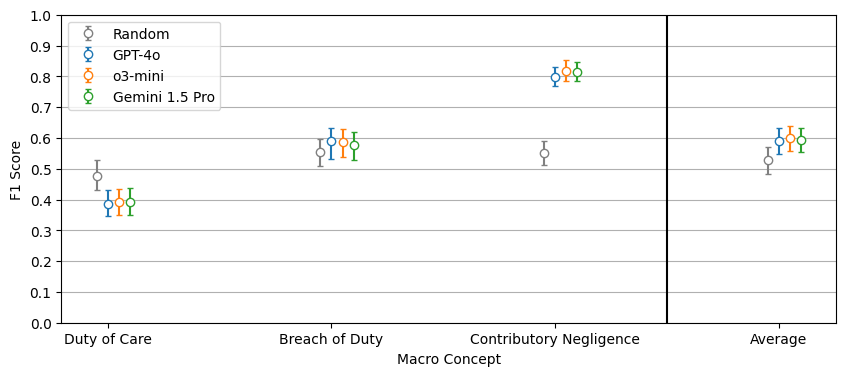

In [ ]:
fig = plt.figure(figsize=(10, 4))

x_axis = np.arange(4)
for i in range(means.shape[0]):
    x_axis = [k-0.05+i*0.05 for k in range(4)]
    if i == 0:
        plt.errorbar(x_axis, means[i], yerr=errors[i], fmt='o', markerfacecolor='white', capsize=2, label=f"{labels[i]}", c='grey')
    else:
        plt.errorbar(x_axis, means[i], yerr=errors[i], fmt='o', markerfacecolor='white', capsize=2, label=f"{labels[i]}")

plt.axvline(2.5, linestyle='solid', c='black')
plt.yticks(np.linspace(0, 1, 11))
plt.grid(axis='y', which='major')
xticks = np.arange(4)
plt.xticks(xticks, labels=x_axis_labels)
plt.xlabel("Macro Concept")
plt.ylabel("F1 Score")
plt.legend()
# plt.savefig("../figures/task_2_final.png", dpi=300, bbox_inches='tight')
plt.show()